# Methods

* In the following, we'll see simple Markowitz Portfolio Optimization (Modern Portfolio Theory).
* In the next episode, a comparison with its contemporary method - Black-Litterman (it uses views of a "well calibrated" portifolio manager) - will be made

In [37]:
import pytz
import scipy
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import scipy.stats as stat
import matplotlib.pyplot as plt

from src import dataset, optimizer
from pathlib import Path
from datetime import datetime, timedelta

tz = pytz.timezone('Brazil/East')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [38]:
def get_rates(symbols, *, from_datetime, to_datetime, timeframe=mt5.MT5_TIMEFRAME_D1):
    mt5.MT5Initialize()
    mt5.MT5WaitForTerminal()
    full_list_rates = []
    for symbol in symbols:
        rates_for_symbol = pd.DataFrame(
            list(mt5.MT5CopyRatesRange(symbol, timeframe, from_datetime, to_datetime)), 
            columns=["time","open","low","high","close","tick_volume","spread","real_volume"])
        rates_for_symbol["symbol"] = symbol
        full_list_rates.append(rates_for_symbol)
    mt5.MT5Shutdown()
    return pd.concat(full_list_rates).set_index('time')

In [39]:
assets = ['ABEV3', 'FLRY3', 'MEAL3', 'CSNA3', 'JHSF3', 'GFSA3']

from_datetime = datetime(2019, 1, 1, tzinfo=tz)
to_datetime = datetime(2019, 12, 31, tzinfo=tz) 

rates = get_rates(assets, 
          from_datetime=from_datetime,
          to_datetime=to_datetime, 
          timeframe=mt5.MT5_TIMEFRAME_D1)

* Closing daily prices are going to be used

In [40]:
close_dayly_prices = pd.DataFrame(
    dict((*rates.groupby("symbol").close, )))

### Average returns

In [41]:
def get_returns(df):
    return df\
           .diff()\
           .div(df.shift())

In [42]:
n_of_weekdays = len(rates.index.unique())

avg_returns = get_returns(close_dayly_prices)\
    .mean()\
    .multiply(n_of_weekdays)

### Covariance

In [43]:
Covariance = get_returns(close_dayly_prices)\
    .cov()\
    .multiply(n_of_weekdays)

### Optimizations parameters

In [44]:
expected_returns = avg_returns # EXPLAIN
expected_Covariance = Covariance # EXPLAIN
risk_free_rate = 0.02 # EXPLAIN
n_assets = len(rates.groupby("symbol"))

## MPT (Modern Portfolio Theory)

Some of the key takeaways from the Modern Portfolio Theory (MPT in short, from Harry Markowitz) are.

* Diversification (buying securities from different sources, with different volatilities) is the main tool used to reduce a portifolio volatility.


* The correlation between assets as well as the estimated returns of assets are the main factor for its accumulated returns.

* Based of the premise of maximizing the aggregated returns and reducing the risk of the portifolio, it is possible to find the *pareto frontier* from which neither the returns can be higher nor the volatility can be smaller.


* This is called `Efficient Frontier`

* We can formulate the optimization problem for this efficient Frontier as follows:

\begin{align}
min\ \ w^t\ R\ w \\
s.t\ w \boldsymbol{1}\ =\ 1\\
w r\ =\ r_{portifolio} 
\end{align}
__________________________________________________________________________________________
Where $w$ is a vector containing the weights for asset allocations, $R$ is the variance-covariance matrix of assets.

1) Tells us that we want to minimize the volatility of the portifolio

2) Is just a constrain for asset allocation weights 

3) Is the equation containing the aggregated returns of the portifolio

It is possible then, to plot all the expected returns for each given volatility of this portifolio:

In [104]:
def compute_volatilities_returns_and_cost(weights):
    returns = avg_returns.values @ weights
    volatilities = np.sqrt(weights.dot(Covariance) @ weights)
    cost = returns / volatilities # Sharpe ratio
    return returns, volatilities, cost

n_points = 5000

weights_arr = np.random.random((n_points, len(assets)))
weights_arr = weights_arr / np.sum(weights_arr, axis=-1, keepdims=True)
returns_volatilities_cost = np.apply_along_axis(compute_volatilities_returns_and_cost, -1, weights_arr)

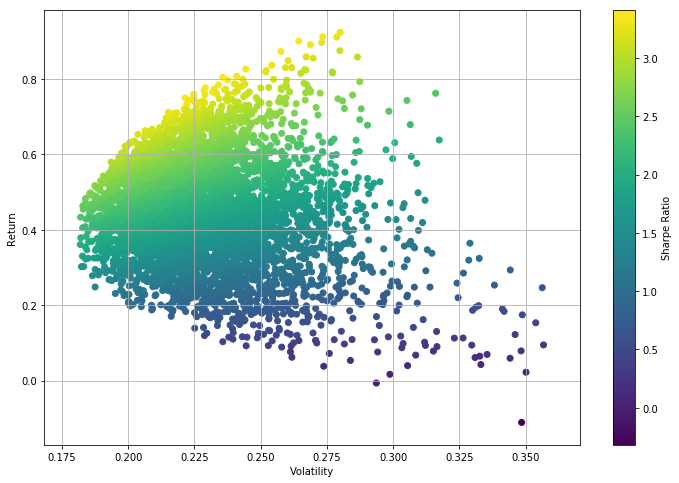

In [105]:
plt.figure(figsize=(12,8))
plt.scatter(returns_volatilities_cost[:, 1], 
            returns_volatilities_cost[:, 0], 
            c = returns_volatilities_cost[:, 2], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.grid()
plt.show()

* One can easily notice that there is a curve (`C` shaped) that goes along the points. This is the *Efficient Frontier* (or *Pareto Frontier* in a multi-objective optimization problem)


* In order to select the best set of weights, one should come up with a "**cost**" function. In this case, we used the *sharpe ratio* as utility (opposite of cost) measure, and put the colors accordingly. So, the lighter the color is, better is its *sharpe ratio*.

* Now, since we've done it by hand, we can simply use *scipy.optimizer* the find that exact set of weights that would optimize our problem;

### Maximize *sharpe ratio* (Minimize the variance and maximize the average returns)

In [107]:
negative_sharpe_ratio = lambda *args: -1.0 * optimizer.sharpe_ratio(*args)

In [110]:
w = optimizer.get_weights_minimizing_metric(
    expected_returns, 
    expected_Covariance, 
    risk_free_rate, 
    negative_sharpe_ratio,
)
print("Sharpe Ratio maximizaztion allocation weigts")
display(w)

Sharpe Ratio maximizaztion allocation weigts


{'ABEV3': 0.0,
 'CSNA3': 0.09713309318724486,
 'FLRY3': 0.21757831159173516,
 'GFSA3': 0.0,
 'JHSF3': 0.5484040769333051,
 'MEAL3': 0.13688451828771545}

### Minimize *volatility*

In [111]:
w = optimizer.get_weights_minimizing_metric(
    expected_returns, 
    expected_Covariance, 
    risk_free_rate, 
    optimizer.volatility,
)
print("Volatility maximizaztion allocation weigts")
display(w)

Volatility maximizaztion allocation weigts


{'ABEV3': 0.3107621460805345,
 'CSNA3': 0.06388743521616025,
 'FLRY3': 0.27035606794784106,
 'GFSA3': 0.04227431335879281,
 'JHSF3': 0.0352738617989237,
 'MEAL3': 0.27744617559774776}

# Backtesting

In [157]:
initial_capital = 10000
optimization_window_days = 252 # roughtly 1 year
returns = get_returns(close_dayly_prices)
initial_weights_guess = np.array([1 / n_assets] * n_assets)

* We are going to rebalance our portifolio each month and compare with a buy and hold strategy

In [ ]:
def rebalance_weights_sharpe_mpt(returns, current_day):
    _from_datetime = datetime.fromtimestamp(current_day.timestamp()) - timedelta(days=optimization_window_days)
    _to_datetime = datetime.fromtimestamp(current_day.timestamp())
    asset_returns_for_optimization = returns[_from_datetime:_to_datetime]
    n_of_weekdaysfor_optimization = len(rates.index.unique())
    
    _expected_returns = asset_returns_for_optimization.mean().multiply(n_of_weekdaysfor_optimization)
    _expected_Covariance = asset_returns_for_optimization.cov().multiply(n_of_weekdaysfor_optimization)
    
    return optimizer.get_weights_minimizing_metric(
        _expected_returns, 
        _expected_Covariance, 
        risk_free_rate, 
        negative_sharpe_ratio,
    )

In [242]:
def rebalance_weights_volatility_mpt(returns, current_day):
    _from_datetime = datetime.fromtimestamp(current_day.timestamp()) - timedelta(days=optimization_window_days)
    _to_datetime = datetime.fromtimestamp(current_day.timestamp())
    asset_returns_for_optimization = returns[_from_datetime:_to_datetime]
    n_of_weekdaysfor_optimization = len(rates.index.unique())
    
    _expected_returns = asset_returns_for_optimization.mean().multiply(n_of_weekdaysfor_optimization)
    _expected_Covariance = asset_returns_for_optimization.cov().multiply(n_of_weekdaysfor_optimization)
    
    return optimizer.get_weights_minimizing_metric(
        _expected_returns, 
        _expected_Covariance, 
        risk_free_rate, 
        optimizer.volatility,
    )

In [ ]:
def rebalance_weights__mpt(returns, current_day):
    _from_datetime = datetime.fromtimestamp(current_day.timestamp()) - timedelta(days=optimization_window_days)
    _to_datetime = datetime.fromtimestamp(current_day.timestamp())
    asset_returns_for_optimization = returns[_from_datetime:_to_datetime]
    n_of_weekdaysfor_optimization = len(rates.index.unique())
    
    _expected_returns = asset_returns_for_optimization.mean().multiply(n_of_weekdaysfor_optimization)
    _expected_Covariance = asset_returns_for_optimization.cov().multiply(n_of_weekdaysfor_optimization)
    
    return optimizer.get_weights_minimizing_metric(
        _expected_returns, 
        _expected_Covariance, 
        risk_free_rate, 
        optimizer.volatility,
    )

In [268]:
capital_history = []
capital = initial_capital
weights = initial_weights_guess.copy()
rebalance_fn = rebalance_weights_sharpe_mpt

for timestamp, returns_row in returns.iterrows():
    if any(returns_row.isna()):
        continue
        
    if timestamp.day == 1:
        weights = np.array(list(rebalance_fn(returns, timestamp).values()))
    capital += capital * returns_row.values @ weights
    capital_history.append(capital)

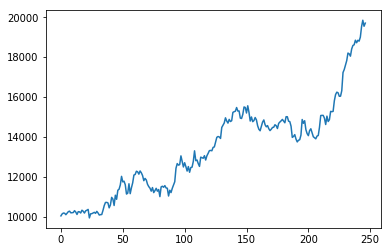

In [270]:
plt.plot(capital_history)